In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:

def substituir_valor(valor):
    if valor < 200000000:
        return "r"
    elif 200000000 <= valor < 500000000:
        return "o"
    elif 500000000 <= valor < 800000000:
        return "y"
    elif 800000000 <= valor < 1000000000:
        return "b"
    else:
        return "g"


def process_files(folder_path, excluded_sources=None, excluded_models=None):
    if excluded_sources is None:
        excluded_sources = []
    if excluded_models is None:
        excluded_models = []

    results = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv') and file_name.startswith('Vazao_bbr_'):
            source = file_name.replace('.csv', '').split('_')[2].upper()  
            if source in excluded_sources:
                continue
            file_path = os.path.join(folder_path, file_name)

            df = pd.read_csv(file_path)

            if 'y_test' not in df.columns:
                print(f"`y_test` não encontrado em {file_name}, ignorando.")
                continue

            df['y_test_cat'] = df['y_test'].apply(substituir_valor)
            for col in df.columns:
                if col.startswith('y_pred'):
                    if col.split('_')[2] in excluded_models:
                        continue
                    df[f'{col}_cat'] = df[col].apply(substituir_valor)
                    matches = (df['y_test_cat'] == df[f'{col}_cat']).sum()
                    total = len(df)
                    accuracy = (matches / total) * 100
                    results.append({
                        'Source': source,
                        'Model': col.split('_')[2],
                        'Accuracy (%)': accuracy
                    })
    return pd.DataFrame(results)


folder_path = '../results/predictions-by-source'
excluded_models = ['PolynomialRegression', 'AdaBoostRegressor', 'ElasticNet', 
                   'LinearRegression', 'MLPRegressor', 'SVR', 'KNeighborsRegressor'] 

results_df = process_files(folder_path, excluded_models=excluded_models)



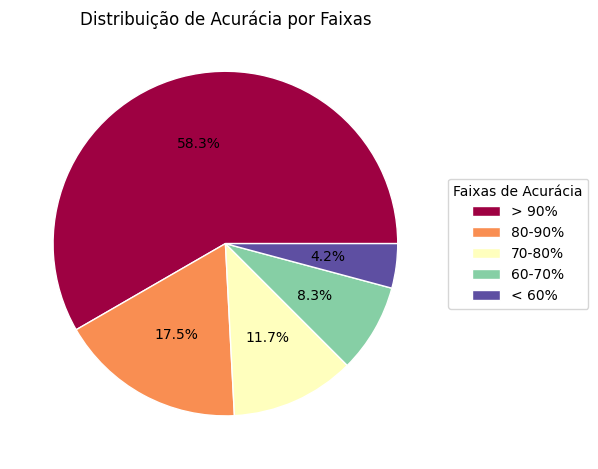

In [18]:
def plot_pie_charts(results_df):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(133)
    bins = [0, 60, 70, 80, 90, 100]
    labels = ['> 90%', '80-90%', '70-80%', '60-70%','< 60%']
    accuracy_dist = pd.cut(results_df['Accuracy (%)'], bins=bins, labels=labels).value_counts()
    

    wedges, texts, autotexts = ax.pie(
        accuracy_dist,
        labels=None,  
        autopct='%1.1f%%',
        colors=plt.cm.Spectral(np.linspace(0, 1, len(accuracy_dist))),
        wedgeprops={'edgecolor': 'white'}
    )
    
    ax.legend(
        wedges,
        labels,  
        title="Faixas de Acurácia",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1)  
    )
    plt.title('Distribuição de Acurácia por Faixas', pad=0.2)
    plt.tight_layout()
    plt.show()
plot_pie_charts(results_df)